# showing how much molecules are in there
and loading them into rdkit readable format

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import plotly.express as px
import seaborn as sns
#import plotly.graph_objects as go  
from matplotlib_venn import venn2

In [11]:
chembl_df = pd.read_csv("data/PDL1-CHEMBL.csv" , delimiter= ";")
chembl_df = chembl_df.rename(columns = {"Smiles" : "SMILES"})
paper_df = pd.read_excel("data/pharmaceuticals-1710563-supplementary.xlsx",header=2)
paper_df = paper_df[paper_df["Activity"] == "ACTIVE"]

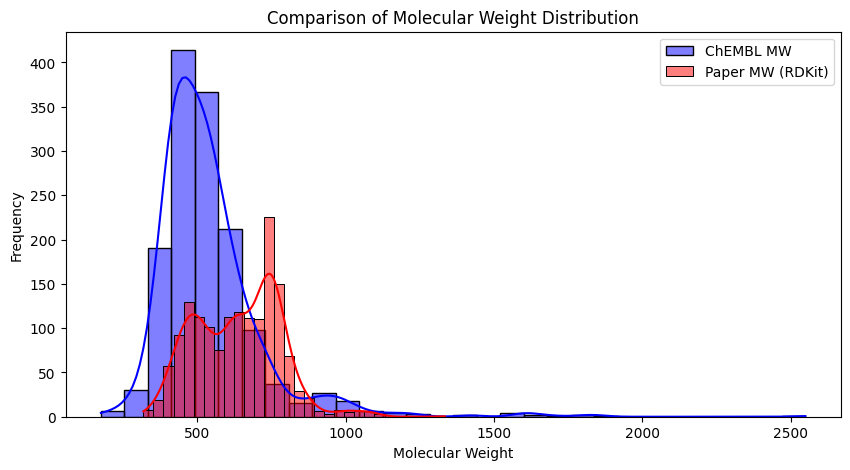

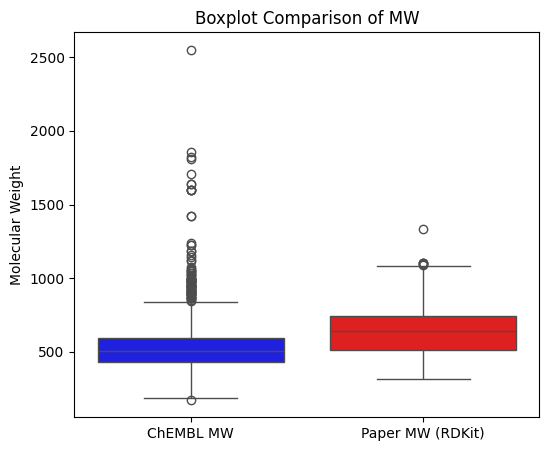

In [14]:
def calc_MW(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Descriptors.MolWt(mol)
    else:
        return None


paper_df["MolW"] = paper_df["SMILES"].apply(calc_MW)
chembl_df["MolW"] = chembl_df["SMILES"].apply(calc_MW)

plt.figure(figsize=(10, 5))
sns.histplot(chembl_df["Molecular Weight"], color="blue", label="ChEMBL MW", bins=30, kde=True, alpha=0.5)
sns.histplot(paper_df["MolW"], color="red", label="Paper MW (RDKit)", bins=30, kde=True, alpha=0.5)
plt.legend()
plt.title("Comparison of Molecular Weight Distribution")
plt.xlabel("Molecular Weight")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(data=[chembl_df["Molecular Weight"], paper_df["MolW"]], palette=["blue", "red"])
plt.xticks([0, 1], ["ChEMBL MW", "Paper MW (RDKit)"])
plt.title("Boxplot Comparison of MW")
plt.ylabel("Molecular Weight")
plt.show()


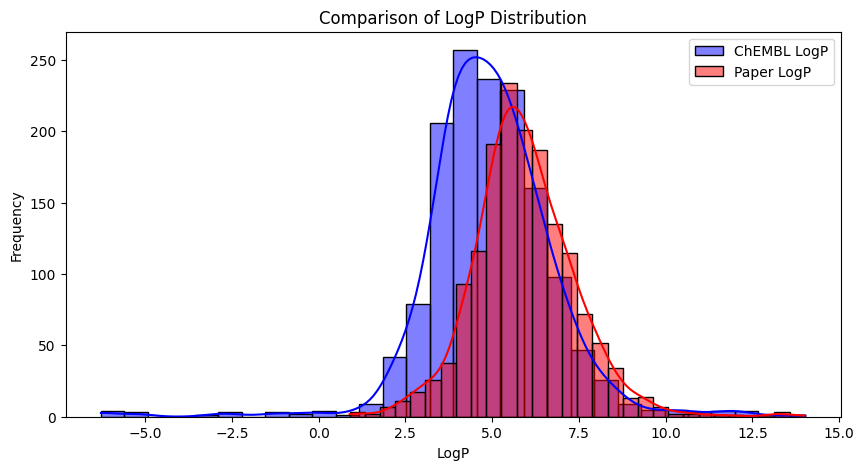

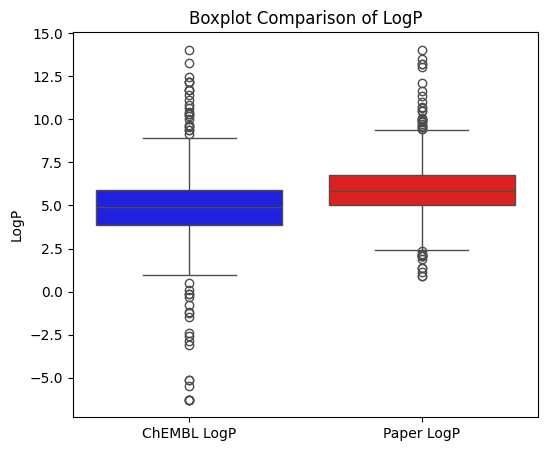

In [33]:
from rdkit.Chem import Crippen
def calc_LogP(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Crippen.MolLogP(mol)
    else:
        return None


paper_df["LogP"] = paper_df["SMILES"].apply(calc_LogP)
paper_df["LogP2"] = paper_df["SMILES"].apply(calc_LogP)
chembl_df["LogP"] = chembl_df["SMILES"].apply(calc_LogP)

plt.figure(figsize=(10, 5))
sns.histplot(chembl_df["LogP"], color="blue", label="ChEMBL LogP", bins=30, kde=True, alpha=0.5)
sns.histplot(paper_df["LogP"], color="red", label="Paper LogP", bins=30, kde=True, alpha=0.5)
plt.legend()
plt.title("Comparison of LogP Distribution")
plt.xlabel("LogP")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(6, 5))
sns.boxplot(data=[chembl_df["LogP"], paper_df["LogP2"]], palette=["blue", "red"])
plt.xticks([0, 1], ["ChEMBL LogP", "Paper LogP"])
plt.title("Boxplot Comparison of LogP")
plt.ylabel("LogP")
plt.show()

# showing the overlap
asvenn diagram


In [18]:
def convert_inchikey(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return Chem.MolToInchiKey(mol)
    else:
        return None

chembl_df["InchiKey"] = chembl_df["SMILES"].apply(convert_inchikey)
paper_df["InchiKey"] = paper_df["SMILES"].apply(convert_inchikey)
chembl_keys = set(chembl_df["InchiKey"])
paper_keys = set(paper_df["InchiKey"])
                 
common = chembl_keys.intersection(paper_keys)
only_chembl = chembl_keys - paper_keys
only_paper = paper_keys - chembl_keys

print(f"Common InChIKeys: {len(common)}")
print(f"Unique to ChEMBL: {len(only_chembl)}")
print(f"Unique to Paper: {len(only_paper)}")

Common InChIKeys: 22
Unique to ChEMBL: 1287
Unique to Paper: 1542


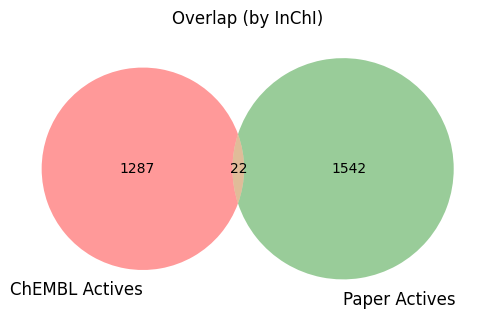

In [20]:
plt.figure(figsize=(6,6))
venn2([chembl_keys, paper_keys], set_labels=("ChEMBL Actives", "Paper Actives"))
plt.title("Overlap (by InChI)")
plt.show()

# showing the distribution of descriptors


# showing the tsne and UMAP
tSNE and UMAP both show interesting qualitative patterns in the data.
1. the datasets are very different and do not overlap so much
2. chembl is much more diverse, and this shows up as the outer clusters in the UMAP
3. the common points seems to be randomly scattered between all the cluster


In [21]:
from rdkit.Chem import rdFingerprintGenerator
mols_chembl = [Chem.MolFromSmiles(smi) for smi in chembl_df["SMILES"]]
mols_paper = [Chem.MolFromSmiles(smi) for smi in paper_df["SMILES"]]
from rdkit.Chem import inchi
inchikeys_chembl = [inchi.MolToInchiKey(m)[:14] for m in mols_chembl]
inchikeys_paper = [inchi.MolToInchiKey(m)[:14] for m in mols_paper]
chembl_uniques = []
common = []
paper_uniques = []
for i,ik in enumerate(inchikeys_chembl):
    if ik not in inchikeys_paper:
        chembl_uniques.append(mols_chembl[i])
    else:
        common.append(mols_chembl[i])
        
for i,ik in enumerate(inchikeys_paper):
    if ik not in inchikeys_chembl:
        paper_uniques.append(mols_paper[i])


MFPGEN = rdFingerprintGenerator.GetMorganGenerator(3,fpSize=4096)
paper_fps = [MFPGEN.GetFingerprintAsNumPy(m) for m in paper_uniques]
chembl_fps = [MFPGEN.GetFingerprintAsNumPy(m) for m in chembl_uniques]
common_fps = [MFPGEN.GetFingerprintAsNumPy(m) for m in common]

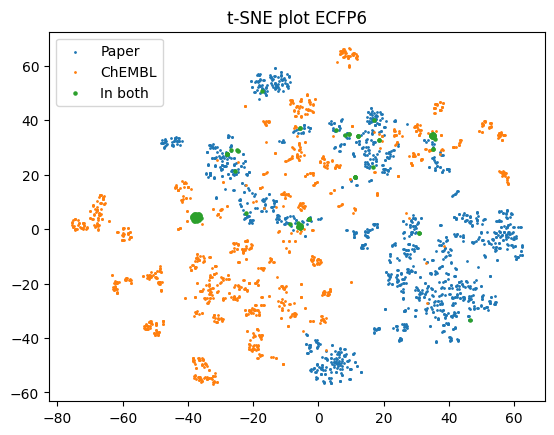

In [26]:
import umap
import numpy as np
from sklearn.manifold import TSNE
um = TSNE(n_components=2,n_jobs=-1)
X_t = um.fit_transform(np.array(paper_fps+chembl_fps+common_fps))
X_p = X_t[:len(paper_fps)]
X_c = X_t[len(paper_fps):len(paper_fps)+len(chembl_fps)]
X_cc = X_t[len(paper_fps)+len(chembl_fps):]
from matplotlib import pyplot as plt
plt.scatter(X_p[:,0],X_p[:,1],s=1,label="Paper")
plt.scatter(X_c[:,0],X_c[:,1],s=1, label="ChEMBL")
plt.scatter(X_cc[:,0],X_cc[:,1],s=5, label="In both")
plt.title("t-SNE plot ECFP6")
plt.legend()
plt.show()

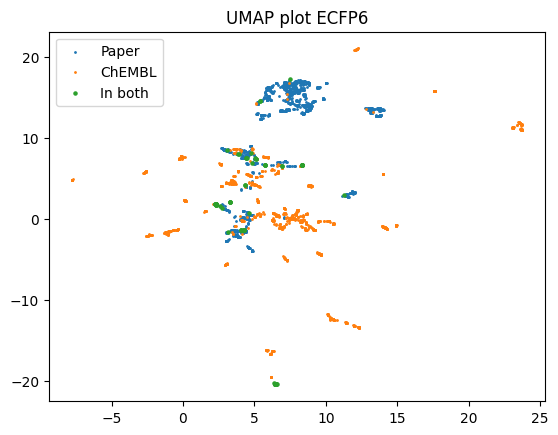

In [27]:
um = umap.UMAP(n_components=2,n_jobs=-1)
X_t = um.fit_transform(np.array(paper_fps+chembl_fps+common_fps))
X_p = X_t[:len(paper_fps)]
X_c = X_t[len(paper_fps):len(paper_fps)+len(chembl_fps)]
X_cc = X_t[len(paper_fps)+len(chembl_fps):]
from matplotlib import pyplot as plt
plt.scatter(X_p[:,0],X_p[:,1],s=1,label="Paper")
plt.scatter(X_c[:,0],X_c[:,1],s=1, label="ChEMBL")
plt.scatter(X_cc[:,0],X_cc[:,1],s=5, label="In both")
plt.title("UMAP plot ECFP6")
plt.legend()
plt.show()